# [Module 1.1] 로컬 스크래치 훈련 (SageMaker 사용 안함)

### 본 워크샵의 모든 노트북은 `conda_python3` 여기에서 작업 합니다.

이 노트북은 아래와 같은 작업을 합니다.
- 기본 환경 세팅
- CIFAR-10 데이터 세트 다운로드 및 데이터 확인
- 모델 하이퍼 파라미터 정의
- 로컬에서 훈련 (단순하게 python train.py 의 형태 임)
- 훈련된 모델의 아티펙트를 리로딩 테스트

## 참고:
- 세이지 메이커로 파이토치 사용 --> [Use PyTorch with the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)

---

## 기본 세팅
사용하는 패키지는 import 시점에 다시 재로딩 합니다.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%store -r local_model_dir

### CIFAR-10 dataset 다운로드
- 유틸리티 함수를 통해서 데이터 세트를 다운로드 합니다. 약 5분 정도 소요 됩니다. 이후에 훈련과 테스트 데이터 세트의 데이터 로더를 리턴 합니다.

In [3]:
from source.utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


### 데이터 확인하기
- 랜덤하게 4장의 사진 이미지를 보면서, 데이터를 확인 합니다.

    horse       car     plane      ship


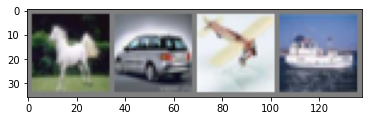

In [4]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

## 모델의 하이퍼파라미터 정의
- 하아퍼 파라미터 오브젝트 이름을 args 로 생성
    - 추후 SageMaker의 Script Mode 사용사에 args 오브젝트가 사용되기에, 이름을 맞추기 위해서 같은 이름을 사용 함
- 아래 파라미터는 로직 확인 용이기에, 훈련이 빨리 끝나기 위한 파라미터 값을 설정 함(에; learning rate)    

In [5]:
class Params:
    def __init__(self):
        self.workers = 4
        self.epochs = 1
        self.batch_size = 64
        self.lr = 0.1
        self.momentum = 0.9        
        self.dist_backend = 'gloo'        
        self.data_dir = '../data'        
        self.num_gpus = 1
        self.model_dir = local_model_dir
        self.current_host = 'dummy-currnet-host'
        self.hosts = 'dummpy-host'
                
args = Params()
print("# of epochs: ", args.epochs)
    

# of epochs:  1


## 로컬에서 스크래치 훈련
- source/train_lib.py 에는 train(args) 함수가 정의 되어 있습니다.
- 이 함수에 인자를 넘기고 훈련을 합니다.
- 중요한 단계를 로깅 합니다.
    - 훈련 환경 셋업, 
    - 데이터 준비 및 데이터 로더 생성
    - 모델 네트워크 로딩
    - 모델 훈련 시작
    - 모델 훈련 완료
    - 모델 아티펙트 저장

In [6]:
import sys, os
# src 폴더 안에 훈련 코드(예: 클래스 정의)가 있어서 경로를 Path에 추가 함
sys.path.append(os.path.join(os.getcwd(), 'source'))

from importlib import reload
import source.train_lib
source.train_lib = reload(source.train_lib)
from source.train_lib import train

In [7]:
%%time 

train(args)

Device Type: cuda
###### Loading Cifar10 dataset
Model network loaded from get_model_network()
Training starts until epochs of 1
Training is finished
the model is saved at ../model/scratch/model.pth
CPU times: user 49.5 s, sys: 9.99 s, total: 59.5 s
Wall time: 42.8 s


### 훈련된 모델의 아티펙트를 리로딩
- 훈련 모델을 리로딩 테스트를 합니다.
- 만약에 모델 로딩이 실패를 하면 디버깅이 필요 합니다.

In [8]:
from importlib import reload
import source.inference
source.inference = reload(source.inference)
from source.inference import model_fn


In [9]:
print("local_model_dir: ", local_model_dir)
model_fn(local_model_dir)

local_model_dir:  ../model/scratch
device:  cuda
model_file_path:  ../model/scratch/model.pth
####### Model is loaded #########


DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)